## Importing Libraries

In [ ]:
# Importing necessary libraries for data processing, ML, and visualization
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
import random
import re
import shutil
import kagglehub
from copy import deepcopy
import warnings
import string
import itertools

from torch.utils.data import Dataset, random_split, DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

## Checkpoints

In [ ]:
CHECKPOINT_DIR = "./checkpoints"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, hyperparameters, subfolder="", data_to_save=None):
    """Salva il checkpoint del modello e rimuove quello precedente."""
    subfolder_path = os.path.join(CHECKPOINT_DIR, subfolder)
    os.makedirs(subfolder_path, exist_ok=True)

    # File corrente e precedente
    filename = f"model_epoch_{epoch}_params_{hyperparameters}.pth"
    filepath = os.path.join(subfolder_path, filename)
    filename_json = f"model_epoch_{epoch}_params_{hyperparameters}.json"
    filepath_json = os.path.join(subfolder_path, filename_json)


    previous_filename = f"model_epoch_{epoch -1}_params_{hyperparameters}.pth"
    previous_filepath = os.path.join(subfolder_path, previous_filename)
    previous_filename_json = f"model_epoch_{epoch -1}_params_{hyperparameters}.json"
    previous_filepath_json = os.path.join(subfolder_path, previous_filename_json)

    # Rimuove il checkpoint precedente
    if epoch > 1 and os.path.exists(previous_filepath) and os.path.exists(previous_filepath_json):
        os.remove(previous_filepath)
        os.remove(previous_filepath_json)

    # Salva il nuovo checkpoint
    if optimizer is not None:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),  # Salvataggio dello stato dell'ottimizzatore
            'epoch': epoch
        }, filepath)
    else:
        torch.save({
            'model_state_dict': model.state_dict(),
            'epoch': epoch
        }, filepath)
    print(f"Checkpoint salvato: {filepath}")

    with open(filepath_json, 'w') as json_file:
      json.dump(data_to_save, json_file, indent=4)


def load_checkpoint(model, optimizer, hyperparameters, subfolder=""):
    """Carica l'ultimo checkpoint disponibile basato sugli iperparametri."""
    subfolder_path = os.path.join(CHECKPOINT_DIR, subfolder)
    if not os.path.exists(subfolder_path):
        print("No checkpoint found, Starting now...")
        return 1, None  # Le epoche iniziano da 1

    # Cerca i file con gli iperparametri specificati
    files = [f for f in os.listdir(subfolder_path) if f"params_{hyperparameters}" in f and f.endswith('.pth')]
    if files:
        # Trova il file con l'epoca più alta
        latest_file = max(files, key=lambda x: int(x.split('_')[2]))
        filepath = os.path.join(subfolder_path, latest_file)
        checkpoint = torch.load(filepath)

        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer is not None:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Trova e carica il file JSON associato
        json_filename = latest_file.replace('.pth', '.json')
        json_filepath = os.path.join(subfolder_path, json_filename)
        json_data = None
        if os.path.exists(json_filepath):
            with open(json_filepath, 'r') as json_file:
                json_data = json.load(json_file)
            print(f"JSON data loaded: {json_filepath}")
        else:
            print(f"No JSON file found for: {latest_file}")

        print(f"Checkpoint found: Resume epoch {checkpoint['epoch'] + 1}")
        return checkpoint['epoch'] + 1, json_data

    print("No checkpoint found, Starting now...")
    return 1, None  # Le epoche iniziano da 1



Mounted at /content/drive


## Shakespeare Dataset

In [ ]:
ALL_LETTERS = "\n !\"&'(),-.0123456789:;>?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz}"
NUM_LETTERS = len(ALL_LETTERS)

def letter_to_index(letter):
    return torch.tensor(ALL_LETTERS.find(letter), dtype=torch.long )

def word_to_indices(word,  n_vocab=NUM_LETTERS):
    '''Returns a list of character indices for a given word'''
    indices = []
    for c in word:
        indices.append(ALL_LETTERS.find(c))
    return indices

def text_transform(text, max_length=80, vocab_size=NUM_LETTERS):
    '''Transform a string into a tensor with indices instead of one-hot encoding.'''
    # Tokenizzazione: converti ogni lettera in un indice
    indices = [ALL_LETTERS.find(char) for char in text]

    # Padding o Troncamento per lunghezza fissa
    if len(indices) < max_length:
        indices += [0] * (max_length - len(indices))  # Pad con zeri (carattere vuoto)
    else:
        indices = indices[:max_length]  # Troncamento se il testo è più lungo

    # Restituisci il tensore di indici
    return torch.tensor(indices, dtype=torch.long)

class CentralizedShakespeareDataset(Dataset):
    def __init__(self, root, split, preprocess_params=None, transform=None):
        """
        Args:
            root (str): Path to the dataset directory.
            split (str): Dataset split, either 'train' or 'test'.
            preprocess_params (dict, optional): Parameters for running preprocess.sh script. Keys include:
                - sharding (str): 'iid' or 'niid' for data partitioning.
                - iu (float): Fraction of users if i.i.d. sampling.
                - sf (float): Fraction of data to sample.
                - k (int): Minimum number of samples per user.
                - t (str): 'user' or 'sample' for train-test partition.
                - tf (float): Fraction of data in training set.
                - raw (bool): Include raw text data.
                - smplseed (int): Seed for sampling.
                - spltseed (int): Seed for splitting.
        """
        self.root = root
        self.split = split
        self.preprocess_params = preprocess_params or {}


        # Ensure the working directory is set to the dataset folder
        os.chdir(self.root)

        # Run preprocessing script if needed
        self._preprocess_data()

        # Load the dataset
        self.data = self._load_data()

        # Create a label map to convert string targets to integers
        #self.label_map = self.create_label_map()

    def _preprocess_data(self):
        """Runs preprocess.sh with the given parameters."""
        cmd = "bash preprocess.sh"

        if 'sharding' in self.preprocess_params:
            cmd += f" -s {self.preprocess_params['sharding']}"
        if 'iu' in self.preprocess_params:
            cmd += f" --iu {self.preprocess_params['iu']}"
        if 'sf' in self.preprocess_params:
            cmd += f" --sf {self.preprocess_params['sf']}"
        if 'k' in self.preprocess_params:
            cmd += f" -k {self.preprocess_params['k']}"
        if 't' in self.preprocess_params:
            cmd += f" -t {self.preprocess_params['t']}"
        if 'tf' in self.preprocess_params:
            cmd += f" --tf {self.preprocess_params['tf']}"
        if 'raw' in self.preprocess_params and self.preprocess_params['raw']:
            cmd += f" --raw"
        if 'smplseed' in self.preprocess_params:
            cmd += f" --smplseed {self.preprocess_params['smplseed']}"
        if 'spltseed' in self.preprocess_params:
            cmd += f" --spltseed {self.preprocess_params['spltseed']}"

        print(f"Running command: {cmd}")
        os.system(cmd)
        os.chdir(self.root)

    def _load_data(self):
        """Loads data from the JSON file in the train or test folder, assuming only one file per folder."""
        folder_path = os.path.join(self.root, 'data', self.split)
        print(f"Absolute folder path: {os.path.abspath(folder_path)}")
        json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

        if len(json_files) != 1:
            raise ValueError(f"Expected exactly one JSON file in {folder_path}, but found {len(json_files)} files.")

        file_path = os.path.join(folder_path, json_files[0])

        # Carica i dati dal file JSON
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Converti la struttura JSON in un DataFrame di pandas
        records = []
        for user, user_data in data['user_data'].items():
            for x, y in zip(user_data['x'], user_data['y']):
                records.append({
                    'client_id': int(user),
                    'x': x,  # Cambiato input in x
                    'y': y   # Cambiato target in y
                })

        return pd.DataFrame(records)

    def create_label_map(self):
        """Creates a mapping from string labels to integer labels."""
        unique_labels = sorted(self.data['y'].unique())
        print(f"Unique labels: {unique_labels}")  # Debug
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        return label_map

    def get_dataframe(self):
        """Returns the dataset as a pandas DataFrame."""
        return self.data

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        sample = {
            'x': self.data.iloc[idx]['x'],
            'y': self.data.iloc[idx]['y']
        }

        sample['x'] = text_transform(sample['x'])  # x is a tensor of one-hot vectors
        sample['y'] = text_transform(sample['y'])  # y is a tensor of one-hot vectors

        return sample['x'], sample['y']


## Shakespeare Model Architecture

In [ ]:
class ShakespeareLSTM(nn.Module):
    def __init__(self, vocab_size=80, embed_dim=8, lstm_hidden_dim=256, seq_len=80, batch_size=32):
        super(ShakespeareLSTM, self).__init__()

        self.seq_len = seq_len
        self.batch_size = batch_size
        self.lstm_hidden_dim = lstm_hidden_dim
        self.vocab_size = vocab_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size=embed_dim, hidden_size=lstm_hidden_dim, batch_first=True)

        # Second LSTM layer
        self.lstm2 = nn.LSTM(input_size=lstm_hidden_dim, hidden_size=lstm_hidden_dim, batch_first=True)

        # Dense output layer
        self.dense = nn.Linear(lstm_hidden_dim, vocab_size)

    def init_hidden(self, batch_size):
        """
        Inizializza lo stato nascosto e la cella della LSTM come tensori di zeri.
        """
        h0 = torch.zeros(2, batch_size, self.lstm_hidden_dim).to(self.device)
        c0 = torch.zeros(2, batch_size, self.lstm_hidden_dim).to(self.device)
        return (h0, c0)

    def forward(self, x, hidden=None):
        # x: (batch_size, seq_len)
        batch_size = x.size(0)
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)

        x, hidden = self.lstm1(x, hidden)  # (batch_size, seq_len, lstm_hidden_dim)

        x, hidden = self.lstm2(x, hidden)  # (batch_size, seq_len, lstm_hidden_dim)

        x = self.dense(x)  # (batch_size, seq_len, vocab_size)

        return x, hidden

## Centralized training functions

In [ ]:
def train_model(model, train_loader, validation_loader, test_loader, optimizer, scheduler, criterion, epochs, hyperparameters):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses, validation_losses, validation_accuracies= [], [], []

    # Load checkpoint if exists
    start_epoch, json_data = load_checkpoint(model, optimizer, hyperparameters)
    if json_data is not None:
        validation_losses = json_data.get('validation_losses', [])
        validation_accuracies = json_data.get('validation_accuracies', [])
        train_losses = json_data.get('train_losses', [])

    if start_epoch >= epochs:
        print(f"Checkpoint found, configuration already completed. Evaluating only on validation set.")
        validation_loss, validation_accuracy = evaluate_model(model, validation_loader, criterion, device)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        return train_losses, validation_losses, validation_accuracies

    # Main training loop
    for epoch in range(start_epoch, epochs + 1):
        model.train()
        epoch_loss = 0
        total_batches = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            try:
                # Ensure inputs and targets are within valid range
                if inputs.max() >= model.vocab_size or inputs.min() < 0:
                    print(f"Invalid input indices found. Max: {inputs.max()}, Min: {inputs.min()}")
                    continue

                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs, _ = model(inputs)  # Ignora gli hidden states


                # Reshape for loss calculation
                batch_size, seq_len, vocab_size = outputs.shape
                outputs = outputs.view(-1, vocab_size)
                targets = targets.view(-1)

                # Create mask for non-padding tokens
                non_pad_mask = targets != 0

                # Only compute loss on non-padding tokens
                valid_outputs = outputs[non_pad_mask]
                valid_targets = targets[non_pad_mask]

                if len(valid_targets) > 0:  # Only compute loss if we have valid tokens
                    loss = criterion(valid_outputs, valid_targets)
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                    total_batches += 1

            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                continue

        if total_batches > 0:
            epoch_loss = epoch_loss / total_batches

        scheduler.step()

        # Validation
        validation_loss, validation_accuracy = evaluate_model(model, validation_loader, criterion, device)
        train_losses.append(epoch_loss)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)


        print(f"Epoch {epoch}/{epochs}, Train Loss: {epoch_loss:.4f}, "
              f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

        # Save checkpoint
        save_checkpoint(
            model, optimizer, epoch, hyperparameters, "Centralized/",
            data_to_save={
                'validation_losses': validation_losses,
                'validation_accuracies': validation_accuracies,
                'train_losses': train_losses
            }
        )

    # Final evaluation on test set
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, validation_losses, validation_accuracies

def evaluate_model(model, test_loader, criterion, device):
    total_loss = 0
    correct = 0
    total = 0
    total_batches = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            try:
                if inputs.max() >= model.vocab_size or inputs.min() < 0:
                    continue

                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs,_ = model(inputs)
                batch_size, seq_len, vocab_size = outputs.shape
                outputs = outputs.view(-1, vocab_size)
                targets = targets.view(-1)

                # Create mask for non-padding tokens
                non_pad_mask = targets != 0
                valid_outputs = outputs[non_pad_mask]
                valid_targets = targets[non_pad_mask]

                if len(valid_targets) > 0:
                    loss = criterion(valid_outputs, valid_targets)
                    total_loss += loss.item()
                    total_batches += 1

                    _, predicted = valid_outputs.max(1)
                    total += valid_targets.size(0)
                    correct += (predicted == valid_targets).sum().item()

            except RuntimeError as e:
                print(f"Error during evaluation: {str(e)}")
                continue

    avg_loss = total_loss / total_batches if total_batches > 0 else float('inf')
    accuracy = correct / total if total > 0 else 0

    return avg_loss, accuracy

## Centralized training Experimetns
Run the cells below before starting any experiments, to regenerate the dataset.

In [ ]:
# Always run before creating new datasets

if os.path.exists("/content/leaf/"):
  # Use shutil.rmtree to remove the folder and its contents
  shutil.rmtree("/content/leaf")
  print(f"Successfully deleted folder leaf")

os.chdir("/content/")
!git clone https://github.com/maxfra01/leaf.git

# -----------------------------------------

preprocess_params = {
        'sharding': 'iid',
        'sf': 0.01,
        'iu': 0.089,
        't': 'sample',
        'tf': 0.8,
    } # Get the full-size dataset

train_dataset_big = CentralizedShakespeareDataset(root="/content/leaf/data/shakespeare", split="train", preprocess_params=preprocess_params)
test_dataset = CentralizedShakespeareDataset(root="/content/leaf/data/shakespeare", split="test", preprocess_params=preprocess_params)
print(f"Train dataset: {len(train_dataset_big)} samples\n"
      f"Test dataset: {len(test_dataset)} samples")

Successfully deleted folder leaf
Cloning into 'leaf'...
remote: Enumerating objects: 772, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 772 (delta 0), reused 0 (delta 0), pack-reused 766 (from 1)
Receiving objects: 100% (772/772), 6.78 MiB | 32.45 MiB/s, done.
Resolving deltas: 100% (363/363), done.
Running command: bash preprocess.sh -s iid --iu 0.089 --sf 0.01 -t sample --tf 0.8
Absolute folder path: /content/leaf/data/shakespeare/data/train
Running command: bash preprocess.sh -s iid --iu 0.089 --sf 0.01 -t sample --tf 0.8
Absolute folder path: /content/leaf/data/shakespeare/data/test
Train dataset: 33761 samples
Test dataset: 600 samples


# Centralized experiments
Here hyperparameters can be changed. Run this cell to start experiments.


Testing with LR=0.01 and WD=0.001
No checkpoint found, Starting now...
Epoch 1/20, Train Loss: 3.4672, Validation Loss: 3.1337, Validation Accuracy: 0.1823
Test Loss: 3.2141, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_1_params_BS64_LR0.01_WD0.001_M0.9.pth
Epoch 2/20, Train Loss: 3.1208, Validation Loss: 3.0974, Validation Accuracy: 0.1823
Test Loss: 3.1735, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_2_params_BS64_LR0.01_WD0.001_M0.9.pth
Epoch 3/20, Train Loss: 3.0600, Validation Loss: 3.0009, Validation Accuracy: 0.1998
Test Loss: 3.0665, Test Accuracy: 0.2133
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_3_params_BS64_LR0.01_WD0.001_M0.9.pth
Epoch 4/20, Train Loss: 2.9495, Validation Loss: 2.8870, Validation Accuracy: 0.2452
Test Loss: 2.9507, Test Accuracy: 0.2483
Chec

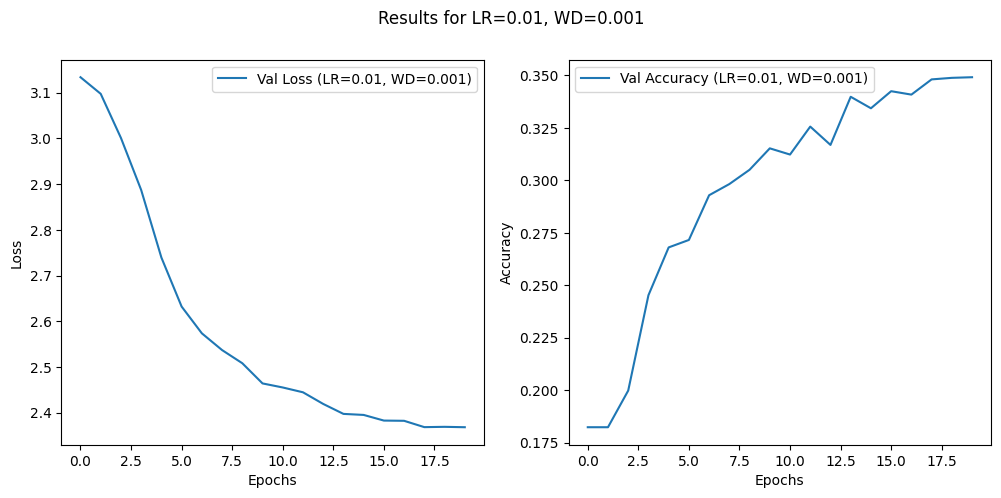


Testing with LR=0.01 and WD=0.0001
No checkpoint found, Starting now...
Epoch 1/20, Train Loss: 3.4734, Validation Loss: 3.1377, Validation Accuracy: 0.1823
Test Loss: 3.2142, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_1_params_BS64_LR0.01_WD0.0001_M0.9.pth
Epoch 2/20, Train Loss: 3.1207, Validation Loss: 3.0978, Validation Accuracy: 0.1823
Test Loss: 3.1746, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_2_params_BS64_LR0.01_WD0.0001_M0.9.pth
Epoch 3/20, Train Loss: 3.0615, Validation Loss: 3.0055, Validation Accuracy: 0.2015
Test Loss: 3.0826, Test Accuracy: 0.2000
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_3_params_BS64_LR0.01_WD0.0001_M0.9.pth
Epoch 4/20, Train Loss: 2.9484, Validation Loss: 2.8695, Validation Accuracy: 0.2180
Test Loss: 2.9614, Test Accuracy: 0.2267


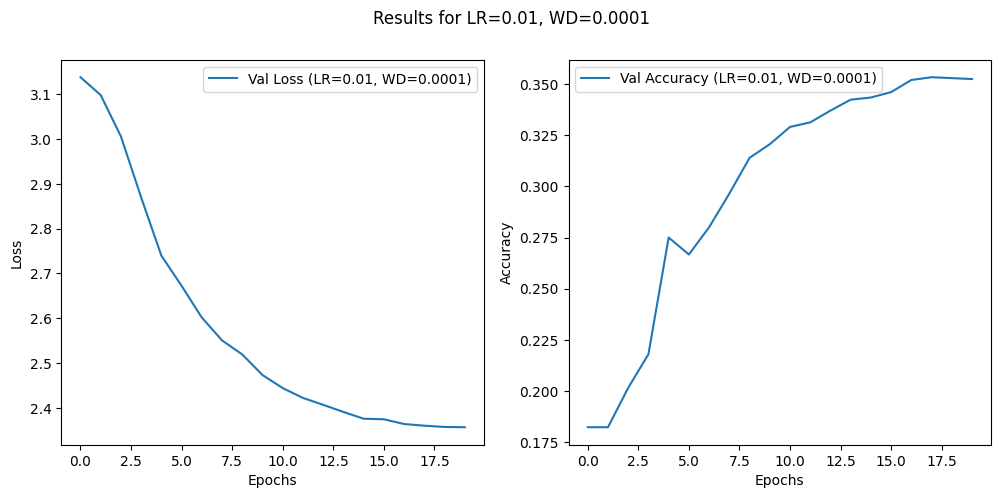


Testing with LR=0.01 and WD=1e-05
No checkpoint found, Starting now...
Epoch 1/20, Train Loss: 3.4567, Validation Loss: 3.1137, Validation Accuracy: 0.1823
Test Loss: 3.1933, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_1_params_BS64_LR0.01_WD1e-05_M0.9.pth
Epoch 2/20, Train Loss: 3.0697, Validation Loss: 2.9983, Validation Accuracy: 0.2070
Test Loss: 3.0949, Test Accuracy: 0.2050
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_2_params_BS64_LR0.01_WD1e-05_M0.9.pth
Epoch 3/20, Train Loss: 2.9564, Validation Loss: 2.8914, Validation Accuracy: 0.2369
Test Loss: 2.9804, Test Accuracy: 0.2433
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_3_params_BS64_LR0.01_WD1e-05_M0.9.pth
Epoch 4/20, Train Loss: 2.8345, Validation Loss: 2.7664, Validation Accuracy: 0.2648
Test Loss: 2.8474, Test Accuracy: 0.2467
Chec

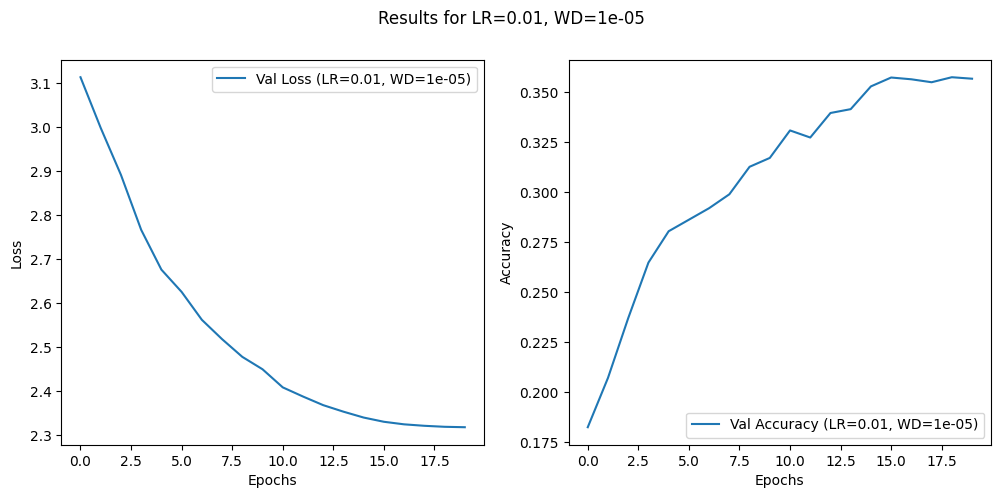


Testing with LR=0.005 and WD=0.001
No checkpoint found, Starting now...
Epoch 1/20, Train Loss: 3.7298, Validation Loss: 3.2080, Validation Accuracy: 0.1823
Test Loss: 3.2766, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_1_params_BS64_LR0.005_WD0.001_M0.9.pth
Epoch 2/20, Train Loss: 3.1524, Validation Loss: 3.1225, Validation Accuracy: 0.1823
Test Loss: 3.1966, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_2_params_BS64_LR0.005_WD0.001_M0.9.pth
Epoch 3/20, Train Loss: 3.1175, Validation Loss: 3.0980, Validation Accuracy: 0.1823
Test Loss: 3.1746, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_3_params_BS64_LR0.005_WD0.001_M0.9.pth
Epoch 4/20, Train Loss: 3.0908, Validation Loss: 3.0654, Validation Accuracy: 0.1830
Test Loss: 3.1395, Test Accuracy: 0.1917


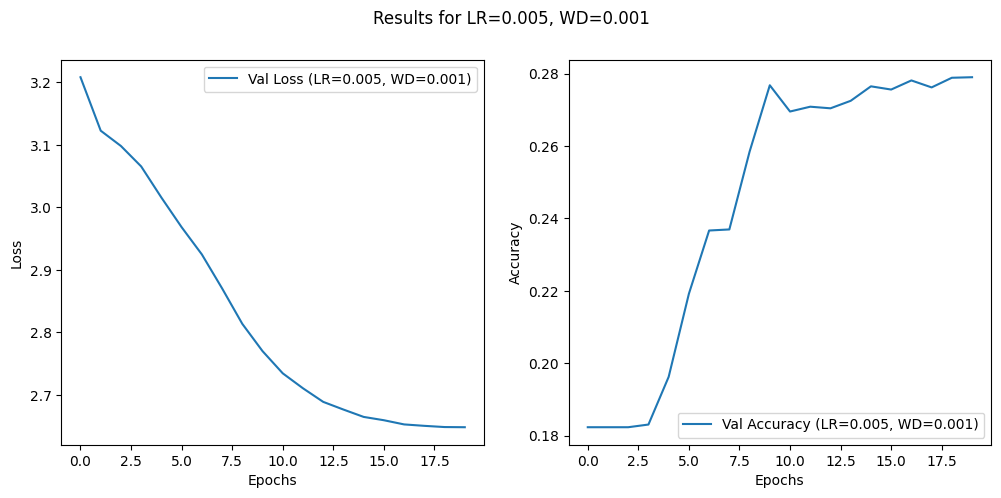


Testing with LR=0.005 and WD=0.0001
No checkpoint found, Starting now...
Epoch 1/20, Train Loss: 3.7341, Validation Loss: 3.2124, Validation Accuracy: 0.1823
Test Loss: 3.2762, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_1_params_BS64_LR0.005_WD0.0001_M0.9.pth
Epoch 2/20, Train Loss: 3.1392, Validation Loss: 3.0953, Validation Accuracy: 0.1823
Test Loss: 3.1694, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_2_params_BS64_LR0.005_WD0.0001_M0.9.pth
Epoch 3/20, Train Loss: 3.0711, Validation Loss: 3.0333, Validation Accuracy: 0.1930
Test Loss: 3.1136, Test Accuracy: 0.2117
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_3_params_BS64_LR0.005_WD0.0001_M0.9.pth
Epoch 4/20, Train Loss: 3.0154, Validation Loss: 2.9840, Validation Accuracy: 0.2337
Test Loss: 3.0658, Test Accuracy: 0.2

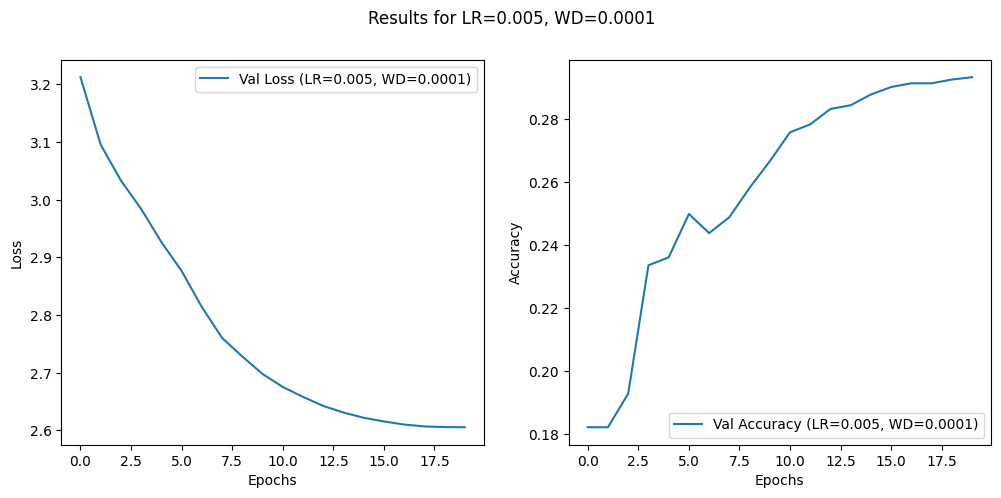


Testing with LR=0.005 and WD=1e-05
No checkpoint found, Starting now...
Epoch 1/20, Train Loss: 3.7325, Validation Loss: 3.2218, Validation Accuracy: 0.1823
Test Loss: 3.2835, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_1_params_BS64_LR0.005_WD1e-05_M0.9.pth
Epoch 2/20, Train Loss: 3.1573, Validation Loss: 3.1243, Validation Accuracy: 0.1823
Test Loss: 3.2023, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_2_params_BS64_LR0.005_WD1e-05_M0.9.pth
Epoch 3/20, Train Loss: 3.1208, Validation Loss: 3.1047, Validation Accuracy: 0.1823
Test Loss: 3.1818, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_3_params_BS64_LR0.005_WD1e-05_M0.9.pth
Epoch 4/20, Train Loss: 3.0971, Validation Loss: 3.0775, Validation Accuracy: 0.1823
Test Loss: 3.1493, Test Accuracy: 0.1883


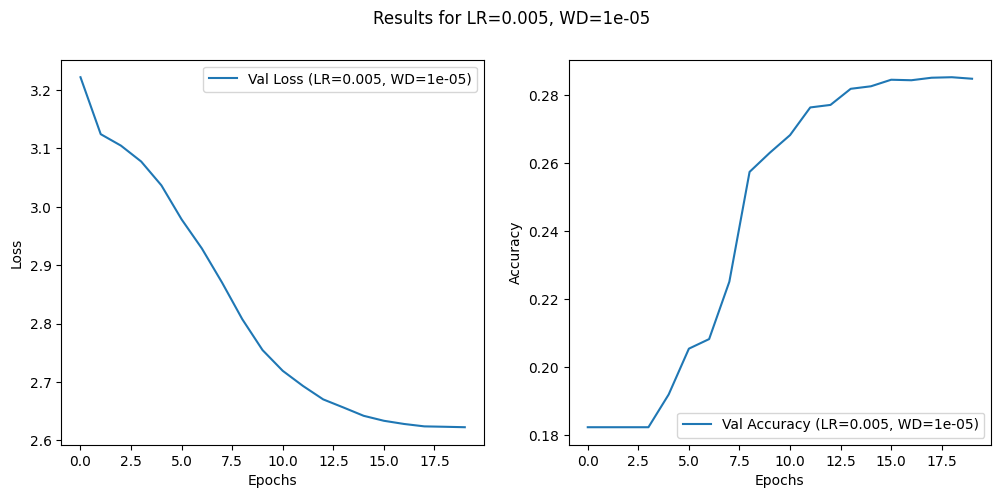


Testing with LR=0.001 and WD=0.001
No checkpoint found, Starting now...
Epoch 1/20, Train Loss: 4.2460, Validation Loss: 4.1123, Validation Accuracy: 0.1823
Test Loss: 4.1156, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_1_params_BS64_LR0.001_WD0.001_M0.9.pth
Epoch 2/20, Train Loss: 3.9816, Validation Loss: 3.8510, Validation Accuracy: 0.1823
Test Loss: 3.8587, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_2_params_BS64_LR0.001_WD0.001_M0.9.pth
Epoch 3/20, Train Loss: 3.7202, Validation Loss: 3.5954, Validation Accuracy: 0.1823
Test Loss: 3.6113, Test Accuracy: 0.1883
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_3_params_BS64_LR0.001_WD0.001_M0.9.pth
Epoch 4/20, Train Loss: 3.4839, Validation Loss: 3.3824, Validation Accuracy: 0.1823
Test Loss: 3.4152, Test Accuracy: 0.1883


KeyboardInterrupt: 

In [ ]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = [0.01, 0.005, 0.001]
MOMENTUM = 0.9
WEIGHT_DECAY= [1e-3, 1e-4, 1e-5]
EPOCHS = 20

hyperparameters = f"BS{BATCH_SIZE}_LR{LEARNING_RATE}_WD{WEIGHT_DECAY}_M{MOMENTUM}"

model_shakespeare = ShakespeareLSTM()

indexes = range(0, len(train_dataset_big))
splitting = train_test_split(indexes, train_size=0.8, random_state=42, shuffle=True)
train_indexes = splitting[0]
val_indexes = splitting[1]

train_dataset = Subset(train_dataset_big, train_indexes)
val_dataset = Subset(train_dataset_big, val_indexes)


# Create Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2)

# Variabile per salvare i migliori risultati
best_result = {
    "hyperparameters": None,
    "val_accuracy": 0.0,
    "val_loss": float('inf'),
}

# Ciclo su tutte le combinazioni di iperparametri
for lr in LEARNING_RATE:
    for wd in WEIGHT_DECAY:
        print(f"\nTesting with LR={lr} and WD={wd}")

        # Inizializzazione del modello e degli ottimizzatori
        model_shakespeare = ShakespeareLSTM()
        optimizer = optim.SGD(
            model_shakespeare.parameters(),
            lr=lr,
            momentum=MOMENTUM,
            weight_decay=wd
        )
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
        criterion = nn.CrossEntropyLoss()

        # Allenamento del modello
        train_losses, val_losses, val_accuracies = train_model(
            model=model_shakespeare,
            train_loader=train_dataloader,
            validation_loader=val_dataloader,
            test_loader=test_dataloader,
            optimizer=optimizer,
            scheduler=scheduler,
            criterion=criterion,
            epochs=EPOCHS,
            hyperparameters=f"BS{BATCH_SIZE}_LR{lr}_WD{wd}_M{MOMENTUM}"
        )

        # Registra i migliori risultati
        final_val_accuracy = val_accuracies[-1]
        final_val_loss = val_losses[-1]
        if final_val_accuracy > best_result["val_accuracy"]:
            best_result["hyperparameters"] = f"LR={lr}, WD={wd}"
            best_result["val_accuracy"] = final_val_accuracy
            best_result["val_loss"] = final_val_loss
            print(f"New best result -> Val Accuracy: {final_val_accuracy:.4f}, Val Loss: {final_val_loss:.4f}")

        # Grafici per ogni combinazione
        plt.figure(figsize=(16, 10))

        # Validation Loss
        plt.subplot(2, 2, 1)
        plt.plot(val_losses, label=f'Val Loss (LR={lr}, WD={wd})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('validation_loss.png')

        # Validation Accuracy
        plt.subplot(2, 2, 2)
        plt.plot(val_accuracies, label=f'Val Accuracy (LR={lr}, WD={wd})')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig('validation_accuracy.png')

        plt.suptitle(f"Results for LR={lr}, WD={wd}")
        plt.tight_layout()
        plt.show()

# Stampa dei migliori iperparametri
print("\nBest Hyperparameters:")
print(f"{best_result['hyperparameters']} -> Val Accuracy: {best_result['val_accuracy']:.4f}, Val Loss: {best_result['val_loss']:.4f}, Test Accuracy: {best_result['test_accuracy']:.4f}, Test Loss: {best_result['test_loss']:.4f}")


## Federated Learning classes

In [ ]:
class Client:

  def __init__(self, model, client_id, data, optimizer_params):
    self.client_id = client_id
    self.data = data
    self.model = model
    self.optimizer_params = optimizer_params


  def train(self, global_weights, local_steps, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model.to(device)
    self.model.load_state_dict(global_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        self.model.parameters(),
        lr=self.optimizer_params['lr'],
        momentum=self.optimizer_params['momentum'],
        weight_decay=self.optimizer_params['weight_decay']
        )
    trainloader = DataLoader(self.data, batch_size=batch_size, shuffle=True,  pin_memory=True)

    steps = 0
    while steps < local_steps:
      for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, _ = self.model(inputs)  # Ignora gli hidden states

        batch_size, seq_len, vocab_size = outputs.shape
        outputs = outputs.view(-1, vocab_size)
        targets = targets.view(-1)

        non_pad_mask = targets != 0

        # Only compute loss on non-padding tokens
        valid_outputs = outputs[non_pad_mask]
        valid_targets = targets[non_pad_mask]

        if len(valid_targets) > 0:  # Only compute loss if we have valid tokens
          loss = criterion(valid_outputs, valid_targets)
          loss.backward()
          optimizer.step()
          steps += 1
        if steps >= local_steps:
          break

    return self.model.state_dict()



class Server:

  def __init__(self, model, clients, test_data, val_data):
    self.model = model
    self.clients = clients
    self.val_data = val_data
    self.test_data = test_data
    self.round_losses = []
    self.round_accuracies = []
    self.selected_clients_per_round = [] #clint selezionati per skewness

  def federated_averaging(self, local_steps, batch_size, num_rounds, fraction_fit, hyperparameters = None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model.to(device)

    # Carica il checkpoint se esiste
    data_to_load = None
    start_epoch, data_to_load = load_checkpoint(self.model,optimizer=None,hyperparameters=hyperparameters, subfolder="Federated_Uniform/")

    if data_to_load is not None:
      self.round_losses = data_to_load['round_losses']
      self.round_accuracies = data_to_load['round_accuracies']
      self.selected_clients_per_round = data_to_load['selected_clients_per_round']


    for round in range(start_epoch, num_rounds+1):

      selected_clients = np.random.choice(self.clients, size=max(1, int(fraction_fit*len(self.clients))), replace=False)

      self.selected_clients_per_round.append([client.client_id for client in selected_clients])


      global_weights = self.model.state_dict()

      # Simulating parallel clients training
      client_weights = {}
      for client in selected_clients:
        client_weights[client.client_id] = client.train(global_weights, local_steps, batch_size)

      new_global_weights = {key: torch.zeros_like(value).type(torch.float32) for key, value in global_weights.items()}

      total_data_size = sum([len(client.data) for client in selected_clients])
      for client in selected_clients:
        scaling_factor = len(client.data) / total_data_size
        for key in new_global_weights.keys():
          new_global_weights[key] += scaling_factor * client_weights[client.client_id][key]

      # Update global model weights
      self.model.load_state_dict(new_global_weights)

      # Evaluate global model every rounds
      if round % 1 == 0:
        loss, accuracy = evaluate_model(self.model, DataLoader(self.val_data, batch_size=batch_size, shuffle=False, pin_memory=True), nn.CrossEntropyLoss(), device)

        self.round_losses.append(loss)
        self.round_accuracies.append(accuracy)
        print(f"Round {round}/{num_rounds} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

        data_to_save = {
          'round_losses': self.round_losses,
          'round_accuracies': self.round_accuracies,
          'selected_clients_per_round': [[client for client in round_clients] for round_clients in self.selected_clients_per_round]  # Serializziamo solo i client_id
      }

        save_checkpoint(self.model, None, round , hyperparameters, "Federated_Uniform/", data_to_save)

    print("Evaluation on test set...")
    loss, accuracy = evaluate_model(self.model, DataLoader(self.test_data, batch_size=batch_size, shuffle=False, pin_memory=True), nn.CrossEntropyLoss(), device)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

     # Plot dei risultati
    plt.figure(figsize=(16, 10))

        # Validation Loss
    plt.subplot(2, 2, 1)
    plt.plot(range(0, num_rounds, 10), self.round_losses, label='Validation Loss')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.title('Validation Loss per Round')
    plt.legend()

        # Validation Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(range(0, num_rounds, 10), self.round_accuracies, label='Validation Accuracy')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy per Round')
    plt.legend()


    plt.tight_layout()
    file_name = f"Shakespeare_fedavg_uniform_{hyperparameters}.jpg"
    plt.savefig(file_name)
    plt.show()


# Federated Learning Experiments
Run all cell below. Hyperparameters can be edited in the very last cell. Run this cell before starting any experimeents, to regenerate the dataset.

In [ ]:
# Always run before creating new datasets

if os.path.exists("/content/leaf/"):
  # Use shutil.rmtree to remove the folder and its contents
  shutil.rmtree("/content/leaf")
  print(f"Successfully deleted folder leaf")

os.chdir("/content/")
!git clone https://github.com/maxfra01/leaf.git

# -----------------------------------------

preprocess_params = {
        'sharding': 'iid',
        'sf': 0.06,
        'iu': 0.089,
        't': 'sample',
        'tf': 0.8,
    } # Get the full-size dataset

train_dataset_big = CentralizedShakespeareDataset(root="/content/leaf/data/shakespeare", split="train", preprocess_params=preprocess_params)
test_dataset = CentralizedShakespeareDataset(root="/content/leaf/data/shakespeare", split="test", preprocess_params=preprocess_params)
print(f"Train dataset: {len(train_dataset_big)} samples\n"
      f"Test dataset: {len(test_dataset)} samples")

Cloning into 'leaf'...
remote: Enumerating objects: 772, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 772 (delta 0), reused 0 (delta 0), pack-reused 766 (from 1)
Receiving objects: 100% (772/772), 6.78 MiB | 12.06 MiB/s, done.
Resolving deltas: 100% (363/363), done.
Running command: bash preprocess.sh -s iid --iu 0.089 --sf 0.06 -t sample --tf 0.8
Absolute folder path: /content/leaf/data/shakespeare/data/train
Running command: bash preprocess.sh -s iid --iu 0.089 --sf 0.06 -t sample --tf 0.8
Absolute folder path: /content/leaf/data/shakespeare/data/test
Train dataset: 202800 samples
Test dataset: 42869 samples


# RUN FedAVG experiments

Hyperparameters can be changed here. Run this cell to start the experiment.

In [ ]:
BATCH_SIZE = 4
LR = 10**(-0.5)
WEIGHT_DECAY = 1e-4
MOMENTUM = 0
ROUNDS = None
LOCAL_STEPS = None
C = 0.1
K=100

optimizer_params = {
      "lr": LR,
      "momentum": MOMENTUM,
      "weight_decay": WEIGHT_DECAY
  }

for ROUNDS, LOCAL_STEPS in [(200,4), (100, 8), (50, 16)]:
  hyperparameters = hyperparameters = f"BS{BATCH_SIZE}_LR{LR}_M{MOMENTUM}_WD{WEIGHT_DECAY}_J{LOCAL_STEPS}_C{C}"

  model_shakespeare = ShakespeareLSTM()

  train_indices, validation_indices = train_test_split(
    range(len(train_dataset_big)), test_size=0.2, random_state=42
  )

  train_dataset = Subset(train_dataset_big, train_indices)
  validation_dataset = Subset(train_dataset_big, validation_indices)

  original_to_subset = {original_idx: subset_idx for subset_idx, original_idx in enumerate(train_indices)}

  clients = []
  for i in range(K):
      client_original_indices = train_dataset_big.data[
          train_dataset_big.data["client_id"] == i
      ].index

      # Converte gli indici originali in indici del subset
      client_subset_indices = [original_to_subset[idx] for idx in client_original_indices if idx in original_to_subset]

      # Crea il subset per il client
      client_data = Subset(train_dataset, client_subset_indices)
      clients.append(Client(model_shakespeare, i, client_data, optimizer_params))



  server_uniform = Server(model_shakespeare, clients, test_dataset, validation_dataset)
  server_uniform.federated_averaging(local_steps=LOCAL_STEPS, batch_size=BATCH_SIZE, num_rounds=ROUNDS, fraction_fit=C,hyperparameters=hyperparameters)

No checkpoint found, Starting now...
Round 1/200 - Loss: 3.7944, Accuracy: 0.1874
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Federated_Uniform/model_epoch_1_params_BS4_LR0.31622776601683794_M0_WD0.0001_J4_C0.1.pth
Round 2/200 - Loss: 3.5306, Accuracy: 0.1874
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Federated_Uniform/model_epoch_2_params_BS4_LR0.31622776601683794_M0_WD0.0001_J4_C0.1.pth
Round 3/200 - Loss: 3.4024, Accuracy: 0.1874
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Federated_Uniform/model_epoch_3_params_BS4_LR0.31622776601683794_M0_WD0.0001_J4_C0.1.pth
Round 4/200 - Loss: 3.3229, Accuracy: 0.1874
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Federated_Uniform/model_epoch_4_params_BS4_LR0.31622776601683794_M0_WD0.0001_J4_C0.1.pth
Round 5/200 - Loss: 3.2669, Accuracy: 0.1874
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shak